# Multi Task Gaussian Process Regression

**Rio Agustian Gilang Fernando**

*University of Science and Technology of Hanoi*

## Setup

### Install

In [9]:
pip install gpytorch scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [1]:
import torch
import gpytorch
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data

### Load Data

In [2]:
df = pd.read_csv('small_dataset.csv')
df

,mod_1,mod_2,FNF,TNF,GF,GS,thermal,epithermal,fast,current,fast_neutron_dose,photon_dose
0,16.91,11.18,20.54,0.63,4.86,5.93,7372700,146300000,187050000,86360000,0.000596,0.000120
1,27.64,19.43,7.71,0.23,6.23,3.89,12808000,176250000,408700000,102200000,0.001327,0.000187
2,38.52,5.95,13.61,1.00,7.82,2.45,9466500,116250000,186700000,65514000,0.000664,0.000102
3,24.59,13.41,2.35,0.35,1.69,7.90,17189000,205000000,1172300000,118480000,0.005073,0.000456
4,24.09,8.04,11.70,0.50,0.51,7.31,21512000,234740000,573880000,138450000,0.002154,0.000330
...,...,...,...,...,...,...,...,...,...,...,...,...
251,24.04,18.26,17.62,0.77,9.46,1.86,7705400,94840000,116150000,53710000,0.000394,0.000075
252,24.74,10.55,20.74,0.91,8.35,3.75,5781900,98064000,115910000,56439000,0.000354,0.000073
253,38.57,16.37,7.13,0.27,2.15,6.69,9107700,179050000,372100000,106840000,0.001049,0.000186
254,27.59,7.34,13.80,0.54,3.81,9.64,9491100,184710000,331570000,110810000,0.001043,0.000166


### Features and Target

In [3]:
X = df[['mod_1', 'mod_2', 'FNF', 'TNF', 'GF', 'GS']].to_numpy()
Y = df[['thermal', 'epithermal', 'fast', 'current', 'fast_neutron_dose', 'photon_dose']].to_numpy()
title = ['Thermal neutron flux',
         'Epithermal neutron flux',
         'Fast neutron flux',
         'Epithermal neutron current',
         'Fast neutron dose',
         'Photon dose']
num_tasks = Y.shape[1]

### Model Definition

In [27]:
#Kernel radial basics function
class GPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)

    self.mean_module = gpytorch.means.MultitaskMean(
        gpytorch.means.ConstantMean(), num_tasks=num_tasks)

    self.covar_module = gpytorch.kernels.MultitaskKernel(
        gpytorch.kernels.RBFKernel(),
        num_tasks=num_tasks,
        rank=5)

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

### Cross Validation

In [28]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kf = KFold(n_splits=5, shuffle=True, random_state=67)
metrics_all = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
  print(f"Calculating fold {fold+1}...")

  X_train, X_test = X[train_idx], X[test_idx]
  Y_train, Y_test = Y[train_idx], Y[test_idx]

  scaler_X = StandardScaler()
  scaler_Y = StandardScaler()

  X_train = scaler_X.fit_transform(X_train)
  X_test = scaler_X.transform(X_test)

  Y_train = scaler_Y.fit_transform(Y_train)

  train_x = torch.tensor(X_train, dtype=torch.float32).to(device)
  train_y = torch.tensor(Y_train, dtype=torch.float32).to(device)
  test_x = torch.tensor(X_test, dtype=torch.float32).to(device)

  likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
      num_tasks=num_tasks).to(device)

  #Training
  model = GPModel(train_x, train_y, likelihood).to(device)
  model.train()
  likelihood.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  max_iter = 500
  for i in range(max_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

  #Evaluation
  model.eval()
  likelihood.eval()

  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))
    mean = preds.mean.cpu().numpy()
    std = preds.stddev.cpu().numpy()

  mean = scaler_Y.inverse_transform(mean)
  Y_test_real = Y_test

  fold_metrics = []

  for i in range(num_tasks):
    rmse = np.sqrt(mean_squared_error(Y_test_real[:, i], mean[:, i]))
    mae = mean_absolute_error(Y_test_real[:, i], mean[:, i])
    r2 = r2_score(Y_test_real[:, i], mean[:, i])

    fold_metrics.append([rmse, mae, r2])

  metrics_all.append(fold_metrics)

metrics_all = np.array(metrics_all)

print("\nAverage cross validation performance")

for i in range(num_tasks):
  rmse_mean = metrics_all[:, i, 0].mean()
  mae_mean = metrics_all[:, i, 1].mean()
  r2_mean = metrics_all[:, i, 2].mean()

  print(f"Task {i+1}")
  print(f"RMSE :  {rmse_mean:.7f}")
  print(f"MAE :  {mae_mean:.7f}")
  print(f"R2 :  {r2_mean:.4f}")
  print("-"*30)

Calculating fold 1...
Calculating fold 2...
Calculating fold 3...
Calculating fold 4...
Calculating fold 5...

Average cross validation performance
Task 1
RMSE :  2278832.6187620
MAE :  1338286.5685520
R2 :  0.9116
------------------------------
Task 2
RMSE :  6049202.9249495
MAE :  4149906.6419306
R2 :  0.9851
------------------------------
Task 3
RMSE :  34604110.0098622
MAE :  23907329.9758673
R2 :  0.9925
------------------------------
Task 4
RMSE :  3294802.4919735
MAE :  2252547.0476621
R2 :  0.9866
------------------------------
Task 5
RMSE :  0.0003026
MAE :  0.0001980
R2 :  0.9803
------------------------------
Task 6
RMSE :  0.0000245
MAE :  0.0000138
R2 :  0.9764
------------------------------


### Final train

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=67)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test  = scaler_X.transform(X_test)

Y_train = scaler_Y.fit_transform(Y_train)
Y_test = scaler_Y.transform(Y_test)

train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(Y_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)
test_y = torch.tensor(Y_test, dtype=torch.float32)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks=num_tasks)

model = GPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 500
for i in range(max_iter):
  optimizer.zero_grad()
  output = model(train_x)
  loss = -mll(output, train_y)
  loss.backward()
  optimizer.step()

model.eval()
likelihood.eval()

with torch.no_grad():
  preds = likelihood(model(test_x))
  mean = preds.mean.numpy()
  std = preds.stddev.numpy()

In [30]:
mean = scaler_Y.inverse_transform(mean)
Y_test_real = scaler_Y.inverse_transform(Y_test)

### Parity Plot

In [31]:
r2_all = []
for i in range(num_tasks):
  r2 = r2_score(Y_test_real[:, i], mean[:, i])
  r2_all.append(r2)

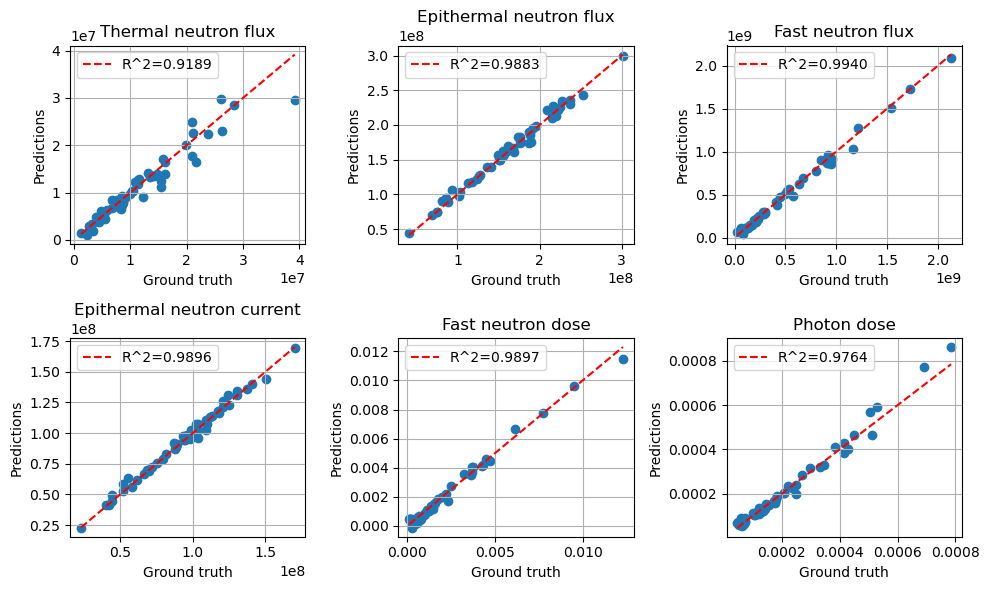

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i in range(num_tasks):
  ax = axes[i]
  ax.scatter(Y_test_real[:, i], mean[:, i])
  ax.plot([Y_test_real[:, i].min(), Y_test_real[:, i].max()],
           [Y_test_real[:, i].min(), Y_test_real[:, i].max()],
          'r--',
          label=f"R^2={r2_all[i]:.4f}")
  ax.set_xlabel("Ground truth")
  ax.set_ylabel("Predictions")
  ax.set_title(f"{title[i]}")
  ax.legend()
  ax.grid(True)
plt.tight_layout()
plt.show()

### Residual Plot

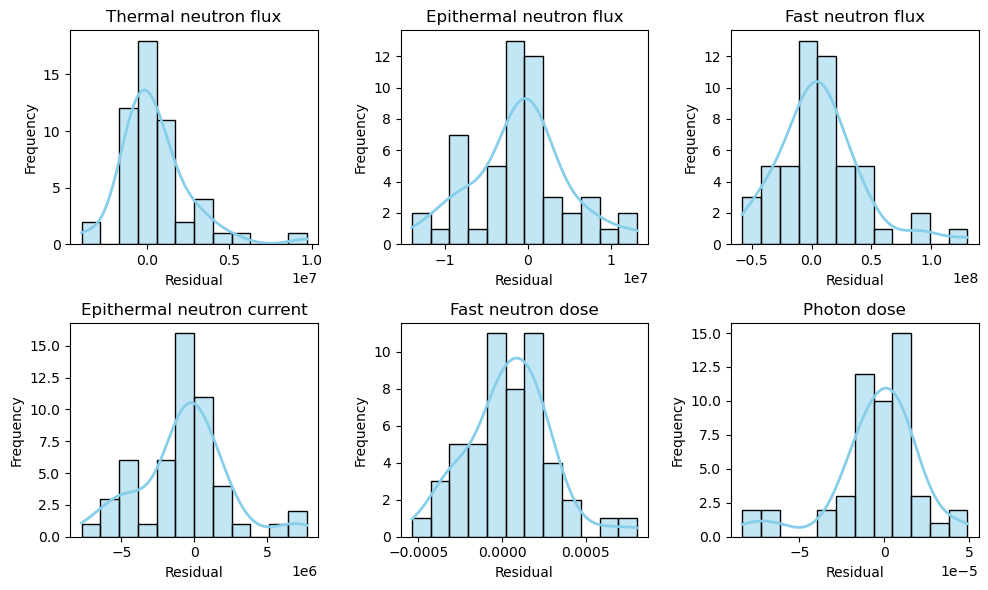

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i in range(num_tasks):
  residuals = Y_test_real[:, i] - mean[:, i]
  ax = axes[i]
  sns.histplot(residuals,
               bins=12,
               kde=True,
               ax=ax,
               color='skyblue',
               edgecolor='black',
               line_kws={'linewidth': 2})
  ax.set_xlabel("Residual")
  ax.set_ylabel("Frequency")
  ax.set_title(f"{title[i]}")
  plt.tight_layout()
plt.show()

### Uncertainty Plot

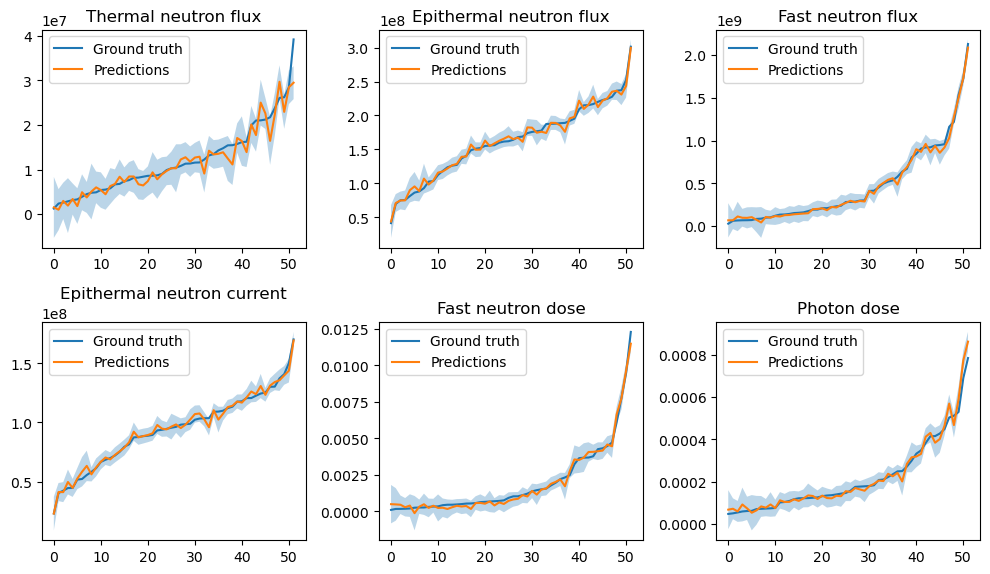

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i in range(num_tasks):
  sorted_idx = np.argsort(Y_test_real[:, i])
  ax = axes[i]
  ax.plot(Y_test_real[:, i][sorted_idx], label='Ground truth')
  ax.plot(mean[:, i][sorted_idx], label='Predictions')

  scaled_std = std[:, i][sorted_idx] * scaler_Y.scale_[i]
  ax.fill_between(
      range(len(sorted_idx)),
      mean[:, i][sorted_idx] - 2*scaled_std,
      mean[:, i][sorted_idx] + 2*scaled_std,
      alpha=0.3
  )
  ax.legend()
  ax.set_title(f"{title[i]}")
plt.tight_layout()
plt.show()

## Hyperparameter Optimaztion

### Models

In [12]:
#Kernel radial basics function
class GPModel_1(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood, rank=1):
    super().__init__(train_x, train_y, likelihood)

    self.mean_module = gpytorch.means.MultitaskMean(
        gpytorch.means.ConstantMean(), num_tasks=num_tasks)

    self.covar_module = gpytorch.kernels.MultitaskKernel(
        gpytorch.kernels.RBFKernel(),
        num_tasks=num_tasks,
        rank=rank)

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

#Kernel matern nu=1.5
class GPModel_2(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood, rank=1):
    super().__init__(train_x, train_y, likelihood)

    self.mean_module = gpytorch.means.MultitaskMean(
        gpytorch.means.ConstantMean(), num_tasks=num_tasks)

    self.covar_module = gpytorch.kernels.MultitaskKernel(
        gpytorch.kernels.MaternKernel(nu=1.5),
        num_tasks=num_tasks,
        rank=rank)

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

#Kernel matern nu=2.5
class GPModel_3(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood, rank=1):
    super().__init__(train_x, train_y, likelihood)

    self.mean_module = gpytorch.means.MultitaskMean(
        gpytorch.means.ConstantMean(), num_tasks=num_tasks)

    self.covar_module = gpytorch.kernels.MultitaskKernel(
        gpytorch.kernels.MaternKernel(nu=2.5),
        num_tasks=num_tasks,
        rank=rank)

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

### Parameters

In [13]:
learning_rate = [0.01, 0.005, 0.0001]
models = ["model_1", "model_2", "model_3"]
ranks = [2, 3, 4, 5, 6]
max_iters = [200, 300, 400, 500]

### Functionalize Cross Validation

In [14]:
def train(model_name, lr, rank, max_iter):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  kf = KFold(n_splits=5, shuffle=True, random_state=67)
  metrics_all = []

  for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    Y_train = scaler_Y.fit_transform(Y_train)

    train_x = torch.tensor(X_train, dtype=torch.float32).to(device)
    train_y = torch.tensor(Y_train, dtype=torch.float32).to(device)
    test_x = torch.tensor(X_test, dtype=torch.float32).to(device)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
        num_tasks=num_tasks).to(device)

    #Check models
    if model_name == "model_1":
      model = GPModel_1(train_x, train_y, likelihood, rank=rank).to(device)
    elif model_name == "model_2":
      model = GPModel_2(train_x, train_y, likelihood, rank=rank).to(device)
    elif model_name == "model_3":
      model = GPModel_3(train_x, train_y, likelihood, rank=rank).to(device)

    #Training
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(max_iter):
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      optimizer.step()

    #Evaluation
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
      preds = likelihood(model(test_x))
      mean = preds.mean.cpu().numpy()

    mean = scaler_Y.inverse_transform(mean)
    Y_test_real = Y_test

    fold_metrics = []

    for i in range(num_tasks):
      r2 = r2_score(Y_test_real[:, i], mean[:, i])

      fold_metrics.append([r2])

    metrics_all.append(fold_metrics)

  metrics_all = np.array(metrics_all)
  r2_all = []
  for i in range(num_tasks):
    r2_mean = metrics_all[:, i].mean()
    r2_all.append(r2_mean)
  print(f"Average R2 = {np.mean(r2_all):.4f}")

  return np.mean(r2_all)

### Best Parameters

In [16]:
learning_rate = [0.01, 0.005, 0.001]
models = ["model_1", "model_2", "model_3"]
ranks = [2, 3, 4, 5, 6]
max_iters = [200, 300, 400, 500]


results = []
j = 1
for lr in learning_rate:
  for model_name in models:
    for rank in ranks:
      for max_iter in max_iters:
        print(f"Calculating experiment {j}...")
        print(f"Model : {model_name} | lr : {lr} | rank : {rank} | max_iter : {max_iter}")
        result = train(model_name, lr, rank, max_iter)
        results.append(([model_name, lr, rank, max_iter], result))
        j += 1

Calculating experiment 1...
Model : model_1 | lr : 0.01 | rank : 2 | max_iter : 200
Average R2 = 0.9299
Calculating experiment 2...
Model : model_1 | lr : 0.01 | rank : 2 | max_iter : 300
Average R2 = 0.9575
Calculating experiment 3...
Model : model_1 | lr : 0.01 | rank : 2 | max_iter : 400
Average R2 = 0.9661
Calculating experiment 4...
Model : model_1 | lr : 0.01 | rank : 2 | max_iter : 500
Average R2 = 0.9699
Calculating experiment 5...
Model : model_1 | lr : 0.01 | rank : 3 | max_iter : 200
Average R2 = 0.9348
Calculating experiment 6...
Model : model_1 | lr : 0.01 | rank : 3 | max_iter : 300
Average R2 = 0.9597
Calculating experiment 7...
Model : model_1 | lr : 0.01 | rank : 3 | max_iter : 400
Average R2 = 0.9675
Calculating experiment 8...
Model : model_1 | lr : 0.01 | rank : 3 | max_iter : 500
Average R2 = 0.9716
Calculating experiment 9...
Model : model_1 | lr : 0.01 | rank : 4 | max_iter : 200
Average R2 = 0.9381
Calculating experiment 10...
Model : model_1 | lr : 0.01 | rank 

In [25]:
with open('hyperparameter_results.txt', 'w') as f:
    f.write("Model, LR, Rank, Max_Iter, Avg_R2\n")
    for params, score in results:
        f.write(f"{params[0]}, {params[1]}, {params[2]}, {params[3]}, {score:.4f}\n")

In [26]:
best_params, best_score = max(results, key=lambda x: x[1])
print(f"Best hyperparameters: {best_params}")
print(f"Best average R2: {best_score}")

Best hyperparameters: ['model_1', 0.01, 5, 500]
Best average R2: 0.972344856646012
